### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, StandardScaler, PowerTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.ticker as mticker
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import shap
import lime
from lime import lime_tabular

### Data Preprocessing

In [3]:
file_path = "C:/Users/Dell/Downloads/SY_NG/Myfile_dataA_5000.csv"
csvFile = pd.read_csv(file_path)

In [4]:
csvFile.shape

(5000, 9)

In [5]:
csvFile = csvFile.dropna()

In [6]:
csvFile.isna().sum()

Gate_Length          0
Work_function        0
Channel_Thickness    0
Oxide_Thickness      0
SD_doping            0
SUBSTRATE_doping     0
Gate_Voltage         0
Drain_Voltage        0
Drain Current        0
dtype: int64

In [7]:
csvFile.head()

,Gate_Length,Work_function,Channel_Thickness,Oxide_Thickness,SD_doping,SUBSTRATE_doping,Gate_Voltage,Drain_Voltage,Drain Current
0,1.220000e-08,4.606941,1.090000e-08,1.350000e-09,3.700000e+20,1.130000e+17,0.078664,0.216504,2.070000e-12
1,1.900000e-08,4.492014,1.090000e-08,1.360000e-09,4.060000e+20,2.210000e+17,0.496761,0.591274,2.120000e-12
2,1.080000e-08,4.331288,1.020000e-08,1.090000e-09,6.650000e+20,2.660000e+17,0.185672,0.798587,2.160000e-12
3,1.340000e-08,4.081299,1.010000e-08,1.200000e-09,4.820000e+20,2.490000e+17,0.166393,0.878277,2.210000e-12
4,1.440000e-08,4.254729,1.080000e-08,1.780000e-09,6.530000e+20,2.630000e+17,0.764250,0.111511,2.260000e-12


In [8]:
selected_features = ["Gate_Length", "Work_function", "Channel_Thickness", "Oxide_Thickness", "SD_doping",
                     "SUBSTRATE_doping", "Gate_Voltage", "Drain_Voltage"]
X = csvFile[selected_features]
y = csvFile["Drain Current"]

In [9]:
y_transformed = PowerTransformer(method='yeo-johnson').fit_transform(y.values.reshape(-1,1)).flatten()

In [10]:
X_transformed = np.log1p(X + 1e-9)

### Data Splitting (80% Training Data and 20% Testing Data)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4000, 8) (4000,)
(1000, 8) (1000,)


### Model: MLP Regressor

In [14]:
np.random.seed(42)
y_train += np.random.normal(loc=0, scale=0.05, size=y_train.shape)

In [15]:
preprocessor = make_pipeline(PolynomialFeatures(degree=1, interaction_only=False),
                             QuantileTransformer(output_distribution='normal'),StandardScaler())

x_train_proc = preprocessor.fit_transform(x_train)
x_test_proc = preprocessor.transform(x_test)

In [16]:
mlp = MLPRegressor(hidden_layer_sizes=(64, 32, 32),
                   activation='relu',
                   alpha=1e-4,
                   batch_size=128,
                   learning_rate_init=0.0005,
                   learning_rate='adaptive',
                   early_stopping=True,
                   validation_fraction=0.2,
                   max_iter=4000,
                   random_state=42,
                   verbose=True)

mlp.fit(x_train_proc, y_train)

Iteration 1, loss = 0.51399455
Validation score: 0.010383
Iteration 2, loss = 0.48003450
Validation score: 0.024102
Iteration 3, loss = 0.46841367
Validation score: 0.038981
Iteration 4, loss = 0.45977350
Validation score: 0.050660
Iteration 5, loss = 0.45142658
Validation score: 0.062393
Iteration 6, loss = 0.44353780
Validation score: 0.070590
Iteration 7, loss = 0.43598442
Validation score: 0.090304
Iteration 8, loss = 0.42634732
Validation score: 0.103909
Iteration 9, loss = 0.41784973
Validation score: 0.117953
Iteration 10, loss = 0.40955029
Validation score: 0.127548
Iteration 11, loss = 0.40025682
Validation score: 0.152672
Iteration 12, loss = 0.39163277
Validation score: 0.162529
Iteration 13, loss = 0.38355193
Validation score: 0.188118
Iteration 14, loss = 0.37393893
Validation score: 0.207388
Iteration 15, loss = 0.36259927
Validation score: 0.233054
Iteration 16, loss = 0.35325822
Validation score: 0.253868
Iteration 17, loss = 0.34306546
Validation score: 0.275196
Iterat

MLPRegressor(batch_size=128, early_stopping=True,
             hidden_layer_sizes=(64, 32, 32), learning_rate='adaptive',
             learning_rate_init=0.0005, max_iter=4000, random_state=42,
             validation_fraction=0.2, verbose=True)

In [17]:
y_pred = mlp.predict(x_test_proc)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [18]:
print(f'Mean Absolute Error: {mae:.6f}')
print(f'Mean Squared Error: {mse:.6f}')
print(f'Root Mean Squared Error: {rmse:.6f}')
print(f'R² Score: {r2:.4f}')

Mean Absolute Error: 0.098901
Mean Squared Error: 0.030070
Root Mean Squared Error: 0.173408
R² Score: 0.9703


### Overfitting Analysis - Learning Curve and Cross-Validation

In [20]:
train_sizes, train_scores, test_scores = learning_curve(mlp, x_train_proc, y_train, cv=5, scoring='r2',
                                                        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

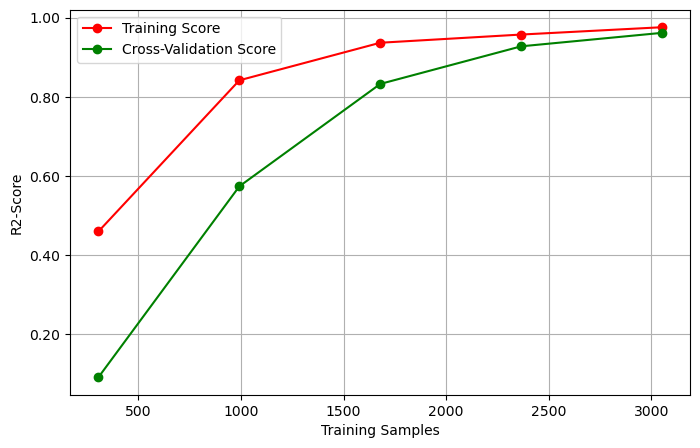

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')
plt.xlabel('Training Samples')
plt.ylabel('R2-Score')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.legend()
plt.grid()
plt.show()

### Model Inference Time

In [23]:
num_inferences = 10
X_test_tensor = tf.convert_to_tensor(x_test_proc)

start_time = time.time()

for _ in range(num_inferences):
    prediction = mlp.predict(X_test_tensor)

end_time = time.time()

total_time = end_time - start_time
average_inference_time = total_time / num_inferences

print(f"Average inference time for ML model: {average_inference_time:.6f} seconds")

Average inference time for ML model: 0.001597 seconds


### SHAP

In [36]:
explainer = shap.Explainer(mlp.predict, x_train)

In [21]:
shap_values = explainer(x_test)

ExactExplainer explainer: 751it [00:35, 16.47it/s]                         


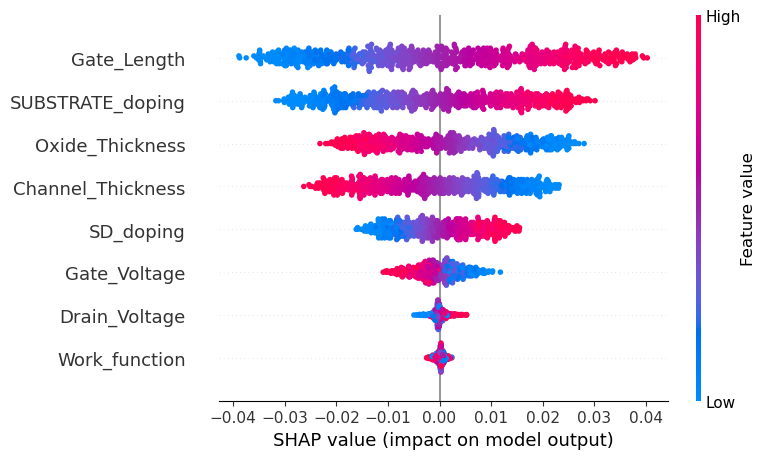

In [22]:
# Summary plot of feature importance
shap.summary_plot(shap_values, x_test, show=False)
plt.savefig("MLP_shap_summary_plot.png", dpi=300, bbox_inches='tight')

In [23]:
shap_values.shape

(750, 8)

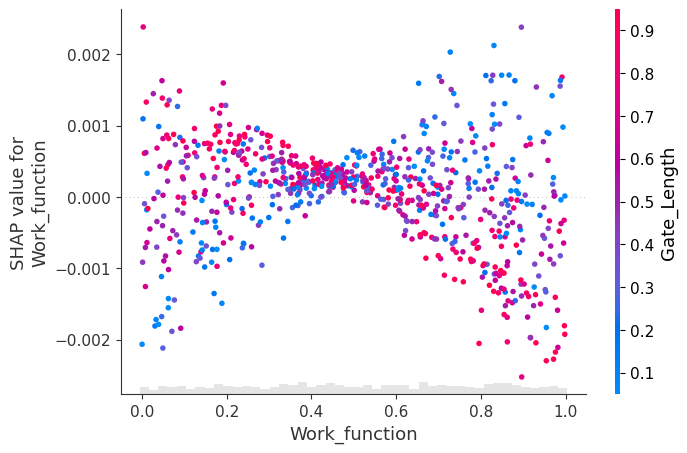

In [24]:
shap.plots.scatter(shap_values[:, "Work_function"], color=shap_values, show=False)
plt.savefig("MLP_shap_scatter_plot_1.png", dpi=300, bbox_inches='tight')

In [25]:
shap.plots.waterfall(shap_values[749], show=False)
plt.savefig("MLP_shap_waterfall_plot.png", dpi=300, bbox_inches='tight')

In [26]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig("MLP_shap_beeswarm_plot.png", dpi=300, bbox_inches='tight')

In [27]:
shap.plots.scatter(shap_values[:, "Drain_Voltage"], color=shap_values, show=False)
plt.savefig("MLP_shap_scatter_plot_2.png", dpi=300, bbox_inches='tight')

### LIME

In [38]:
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), feature_names=x_train.columns, mode='regression')

In [39]:
j = 5
exp = lime_explainer.explain_instance(x_test.values[j], mlp_reg.predict, num_features=6)
print(exp)

In [40]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns.values.tolist(), class_names=['MEDV'], 
                                                   verbose=True, mode='regression')

In [41]:
j = 5
exp = explainer.explain_instance(x_test.values[j], mlp_reg.predict, num_features=6)

Intercept 0.11087330311374093
Prediction_local [0.06328621]
Right: 0.0811628165966533


In [42]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("MLP_lime_explanation_plot_1.png", dpi=300, bbox_inches='tight')

In [43]:
exp.as_list()

[('Oxide_Thickness > 0.74', -0.022861377567149246),
 ('Channel_Thickness > 0.75', -0.02224395328511807),
 ('0.50 < Gate_Length <= 0.76', 0.011238805601003928),
 ('0.25 < SUBSTRATE_doping <= 0.50', -0.009736120642385496),
 ('0.25 < SD_doping <= 0.50', -0.005037025021289589),
 ('Drain_Voltage > 0.75', 0.0010525749265702367)]

In [44]:
j = 5
exp = explainer.explain_instance(x_test.values[j], mlp_reg.predict, num_features=6)

Intercept 0.11134323232882125
Prediction_local [0.06123516]
Right: 0.0811628165966533


In [45]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("MLP_lime_explanation_plot_2.png", dpi=300, bbox_inches='tight')

In [46]:
exp.as_list()

[('Oxide_Thickness > 0.74', -0.023182554773961868),
 ('Channel_Thickness > 0.75', -0.023069912668681563),
 ('0.50 < Gate_Length <= 0.76', 0.012774839000771561),
 ('0.25 < SUBSTRATE_doping <= 0.50', -0.010161894016897294),
 ('0.25 < SD_doping <= 0.50', -0.0043455834780618844),
 ('0.50 < Gate_Voltage <= 0.75', -0.0021229629288741264)]

### How NN Model Influences eXplainable AI (XAI)

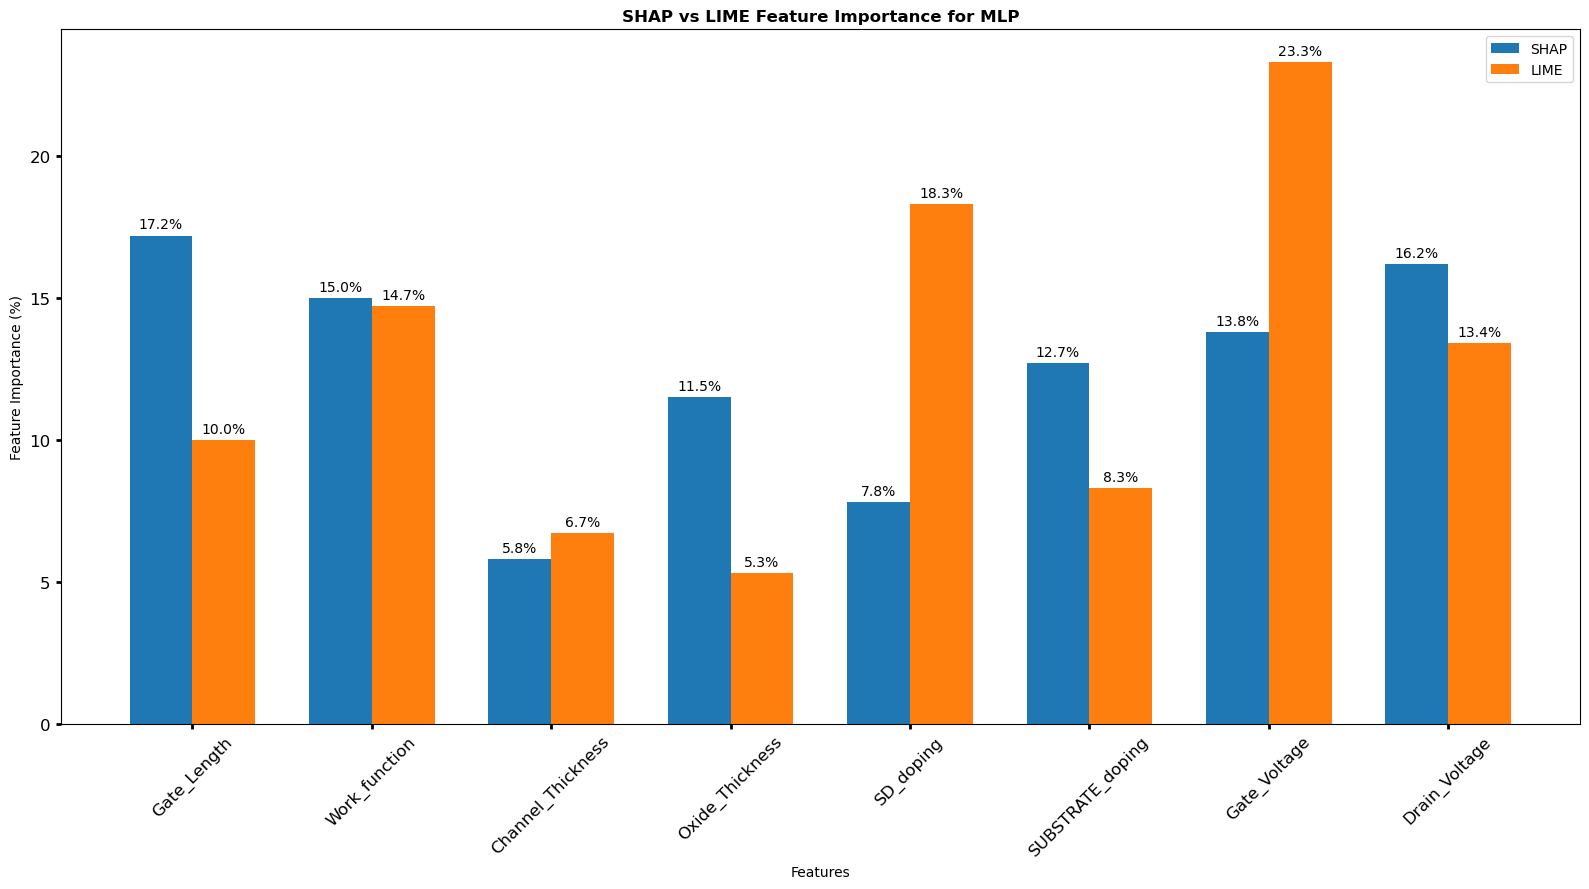

In [48]:
features = ['Gate_Length', 'Work_function', 'Channel_Thickness', 'Oxide_Thickness',
            'SD_doping', 'SUBSTRATE_doping', 'Gate_Voltage', 'Drain_Voltage']

shap_values = {
    'MLP': [17.2, 15.0, 5.8, 11.5, 7.8, 12.7, 13.8, 16.2]
}

lime_values = {
    'MLP': [10.0, 14.7, 6.7, 5.3, 18.3, 8.3, 23.3, 13.4],
}

def plot_feature_importance(shap_values, lime_values, model_name):
    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 9))
    
    rects1 = ax.bar(x - width/2, shap_values, width, label='SHAP')
    rects2 = ax.bar(x + width/2, lime_values, width, label='LIME')

    ax.set_xlabel('Features')
    ax.set_ylabel('Feature Importance (%)')
    ax.set_title(f'SHAP vs LIME Feature Importance for {model_name}', fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=12, width=2)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

for model_name in shap_values.keys():
    plot_feature_importance(shap_values[model_name], lime_values[model_name], model_name)
